# SWW Reconstruction Algorithm Simulation V2
## Michael Hétu
## November 2023

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal.windows as windows

from scipy.fft import fft, fftshift, ifft, ifftshift, fftfreq
from scipy.constants import c, pi

matplotlib.style.use('bmh')

In [2]:
Bi = 5e6 # Chirp bandwidth
fs = 10e6 # Sample rate
N = 2**7 #Number of samples, power of 2
Tp = N/fs # Chirp duration 

nsp = 5 # Number of sub pulses
Bft = Bi*nsp # Set reconstucted bandwidth here

delf = Bi #the frequency step between broadband pulses

samp_shift = int(N/3) #Delay time, max resolved delay is Tp/2
time_delay = samp_shift *(1/fs)
print("Number of samples:", N)
print("Delay time:", time_delay, "s. Sample shift:", samp_shift)
print("Length of a full chirp:", Tp)

K = Bi/(Tp) # Linear chirp frequency rate
W = windows.boxcar(int(N)) # FFT window 

t = np.linspace(0, Tp, N) # Time point vector for digitized waveform

# Initializing reference waveform
def chirp(t, K):
    #return np.array(np.exp(1j*np.pi*K*t**2))
    return np.sin(np.pi * K * t**2)
    #return np.exp(1j * np.pi *K * t**2)

def complex_noise():
    real_noise = np.random.normal(0, .02, N)
    imaginary_noise = np.random.normal(0, .2, N)
    return real_noise 


Number of samples: 128
Delay time: 4.2e-06 s. Sample shift: 42
Length of a full chirp: 1.28e-05


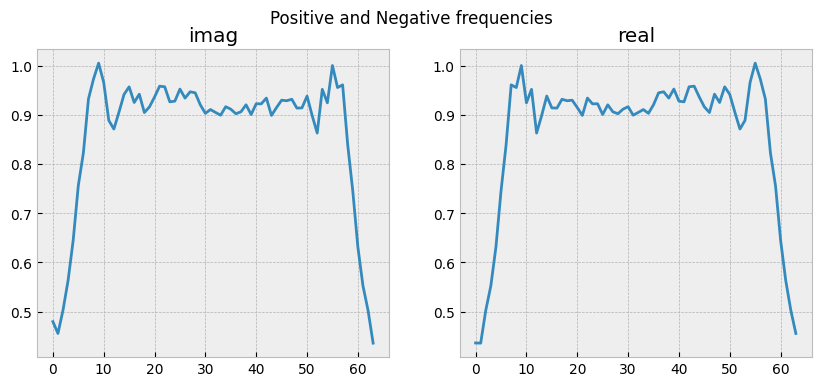

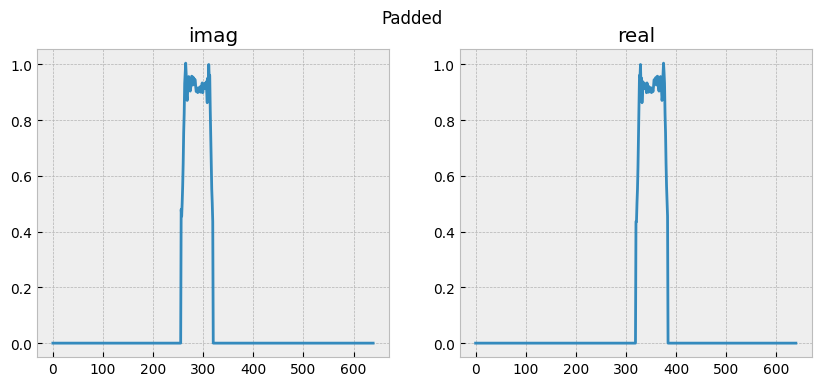

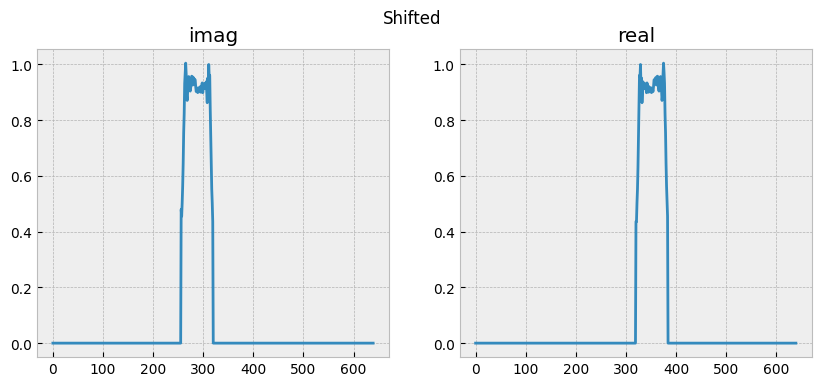

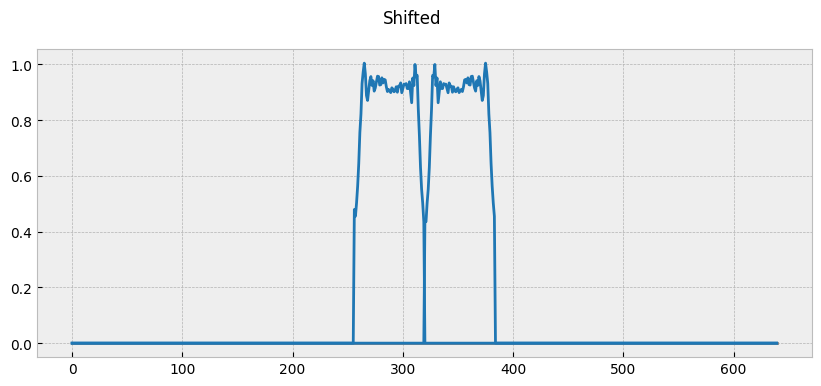

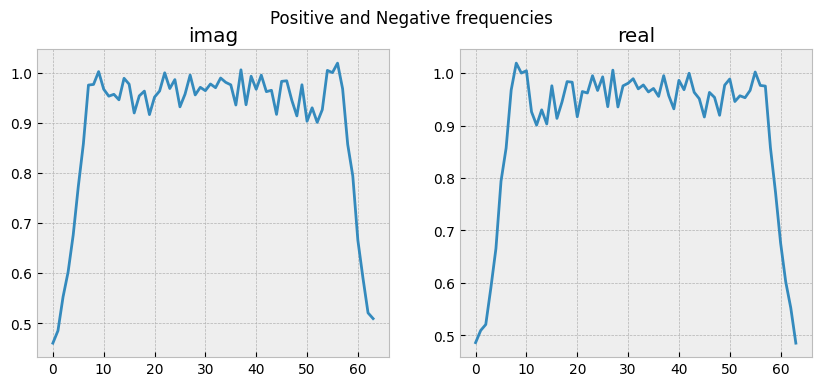

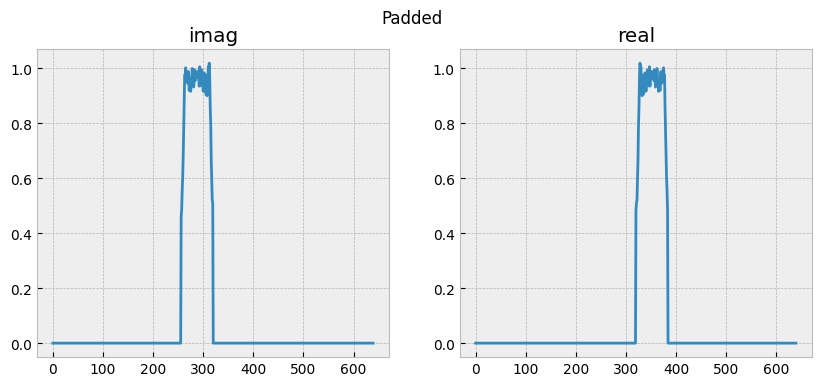

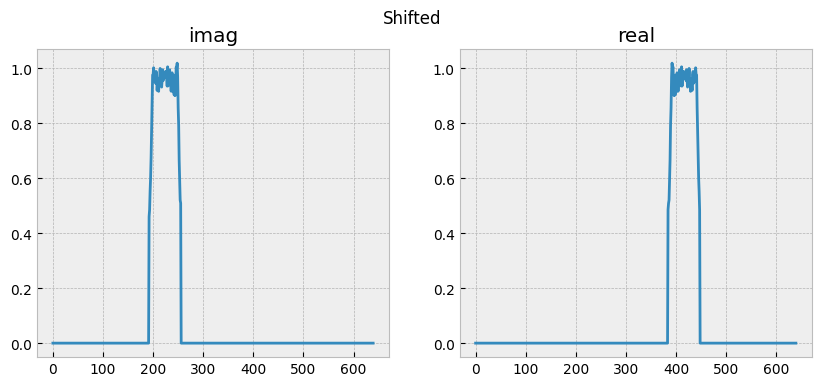

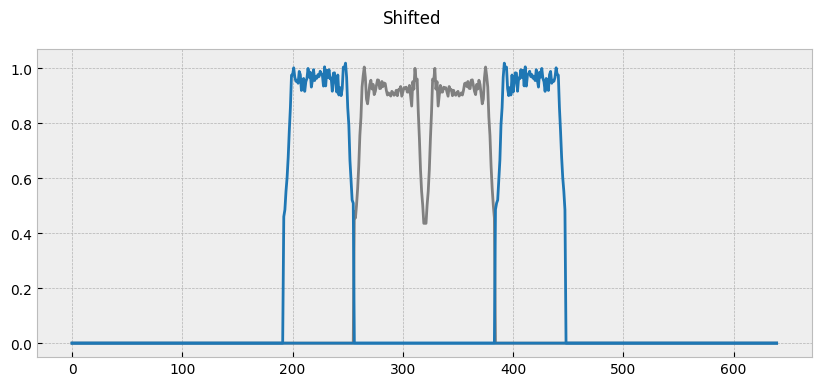

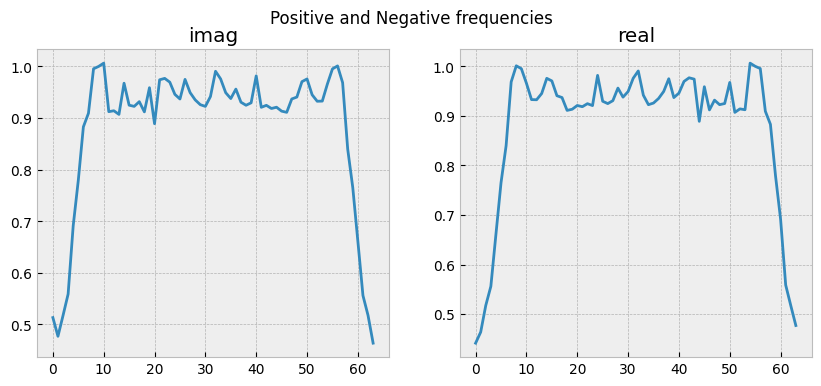

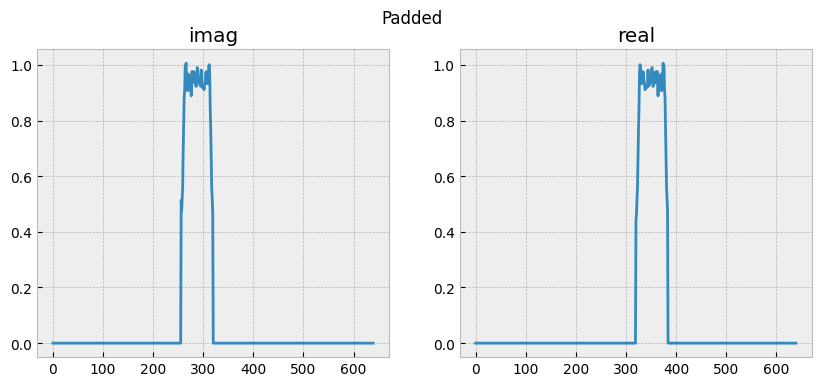

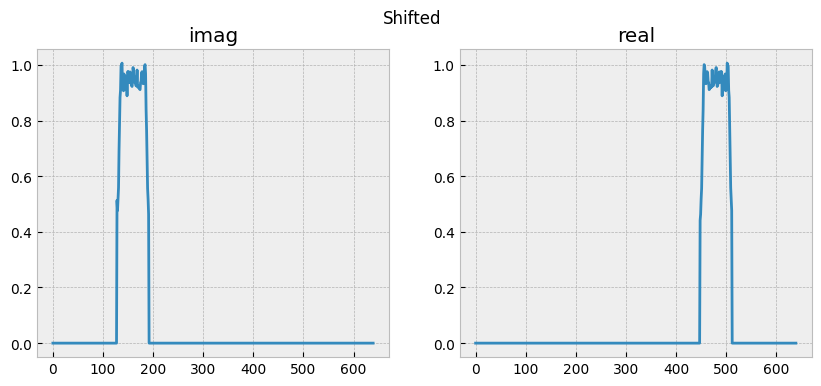

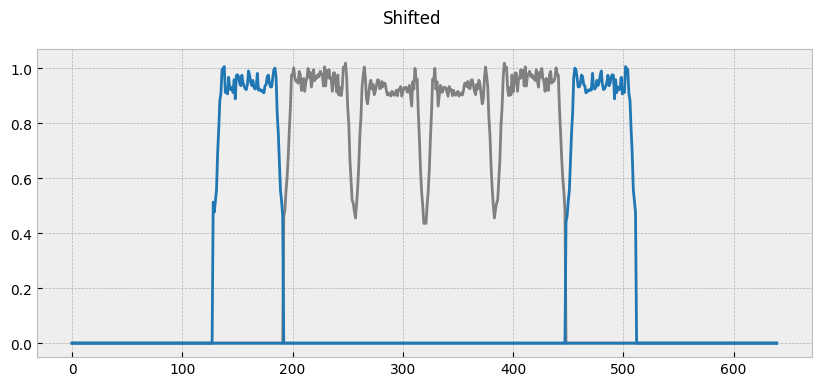

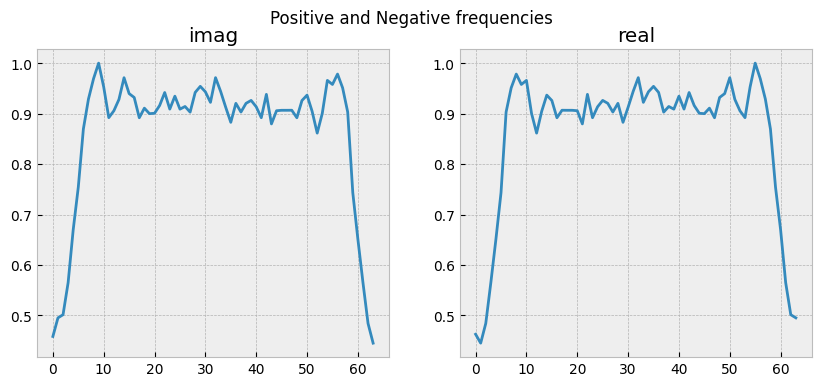

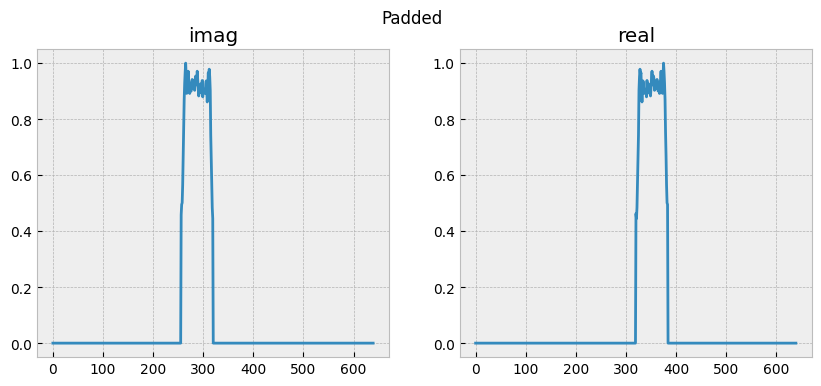

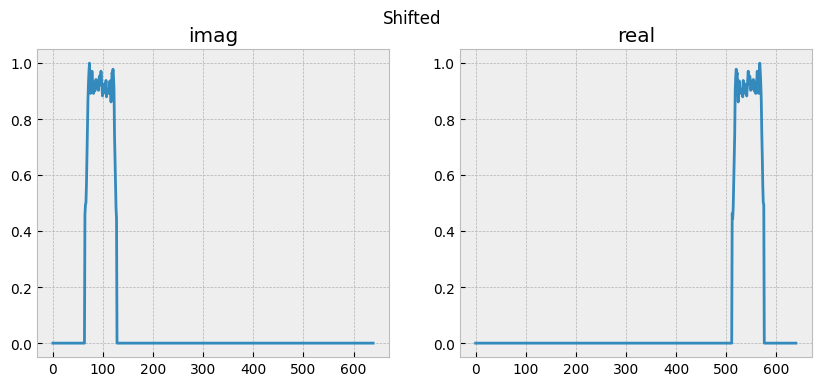

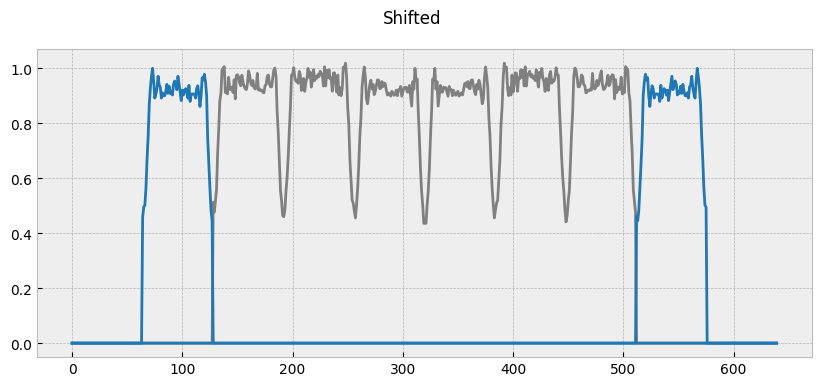

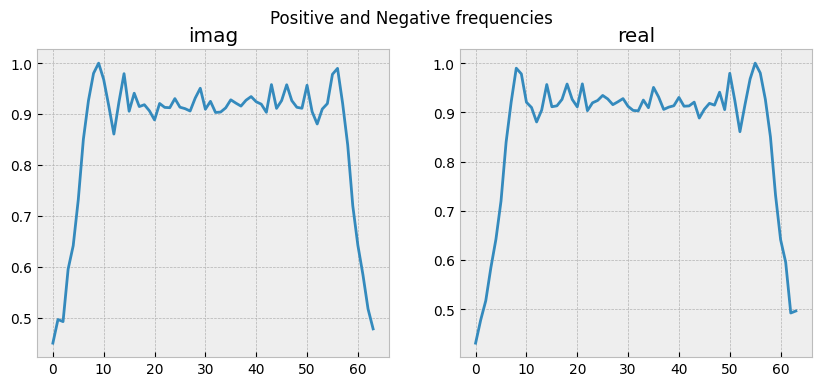

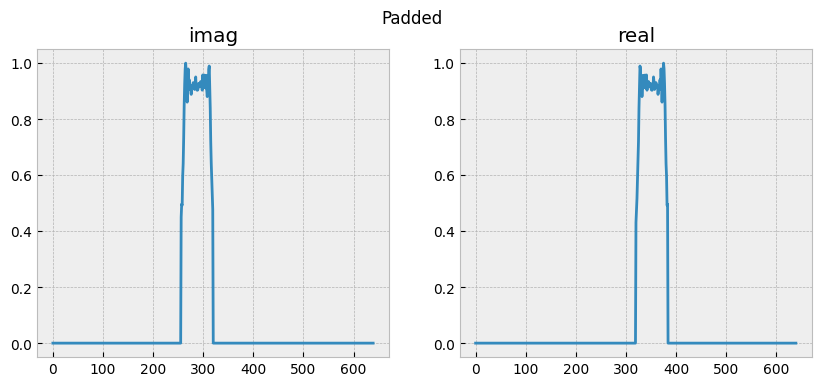

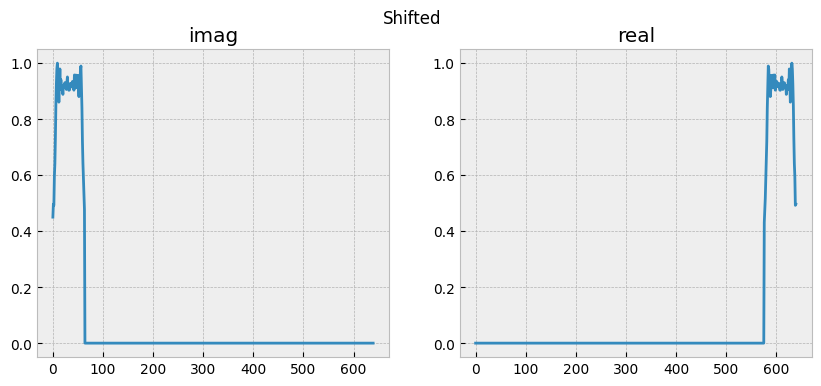

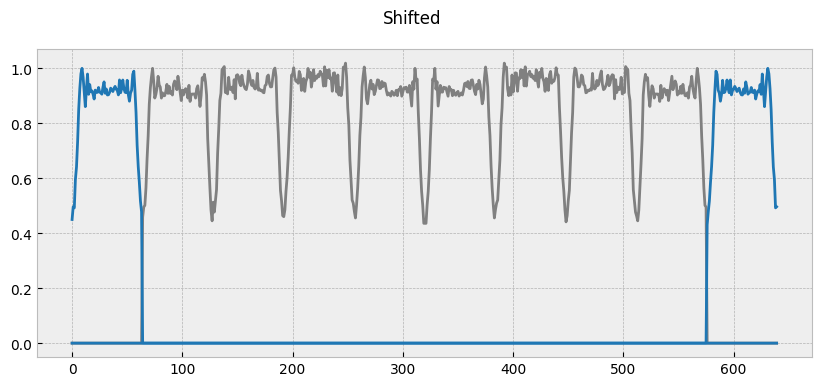

In [8]:
Nf = int(N*nsp/2)
N2 = int(N/2)
dft_stack = np.zeros(Nf*2, dtype = np.complex128)

gain = np.array([1, 1, 1, 1, 1])

for i in range(nsp):

    # Initializing reference waveform
    base_chirp = chirp(t, K) 
    
    # Initializing reflected waveform (echo)
    rx_chirp = gain[i]*(np.roll(base_chirp, -samp_shift) + np.random.normal(0, 0.02, N))

    ref_chirp = gain[i]*base_chirp# + np.random.normal(0, 0.002, N)
    
    # FFTs and FFTshift to center at 0Hz
    ref_dft = fftshift(fft((ref_chirp*W)))
    rx_dft = fftshift(fft(rx_chirp*W))

    freqs = fftshift(fftfreq(N, 1/fs)) #Frequency range

    mf_dft = ref_dft * np.conj(rx_dft)

    #Seperate matched filter into real and imaginary components
    dft_real = mf_dft[:N2]/np.max(mf_dft[:N2])
    dft_imag = mf_dft[N2:]/np.max(mf_dft[N2:])

    f, ax = plt.subplots(1,2, figsize = (10,4))
    ax[0].plot(np.abs(dft_imag))
    ax[1].plot(np.abs(dft_real))
    ax[0].set_title("imag")
    ax[1].set_title('real')
    plt.suptitle("Positive and Negative frequencies")

    if i == 4 & nsp == 5:
        plt.savefig('stack1.png', dpi = 300)
        
    plt.show()
    
    #Sufficiently pad each side
    dft_real_pad = np.pad(dft_real, (Nf, Nf-N2), mode = 'constant', constant_values = (0,0))
    dft_imag_pad = np.pad(dft_imag, (Nf-N2, Nf), mode = 'constant', constant_values = (0,0))

    f, ax = plt.subplots(1,2, figsize = (10,4))
    ax[0].plot(np.abs(dft_imag_pad))
    ax[1].plot(np.abs(dft_real_pad))
    ax[0].set_title("imag")
    ax[1].set_title('real')
    plt.suptitle("Padded")
    if i == 4 & nsp == 5:
        plt.savefig('stack2.png', dpi = 300)
    plt.show()
    
    #Perform a circular shift corresponding to the frequency spacing between broadband pulses
    dft_real_shift = np.roll(dft_real_pad, int(i*len(mf_dft)/2))
    dft_imag_shift = np.roll(dft_imag_pad, -int(i*len(mf_dft)/2))

    f, ax = plt.subplots(1,2, figsize = (10,4))
    ax[0].plot(np.abs(dft_imag_shift))
    ax[1].plot(np.abs(dft_real_shift))
    ax[0].set_title("imag")
    ax[1].set_title('real')
    plt.suptitle("Shifted")
    if i == 4 & nsp == 5:
        plt.savefig('stack3.png', dpi = 300)
    plt.show()

    f, ax = plt.subplots(figsize = (10,4))
    ax.plot(np.abs(dft_stack), color = 'grey')
    
    #Add to the stack array and repeat
    dft_stack += dft_real_shift
    dft_stack += dft_imag_shift

    ax.plot(np.abs(dft_real_shift), color = '#1f77b4')
    ax.plot(np.abs(dft_imag_shift), color = '#1f77b4')
    plt.suptitle("Shifted")
    if i == 4 & nsp == 5:
        plt.savefig('stack4.png', dpi = 300)
    plt.show()

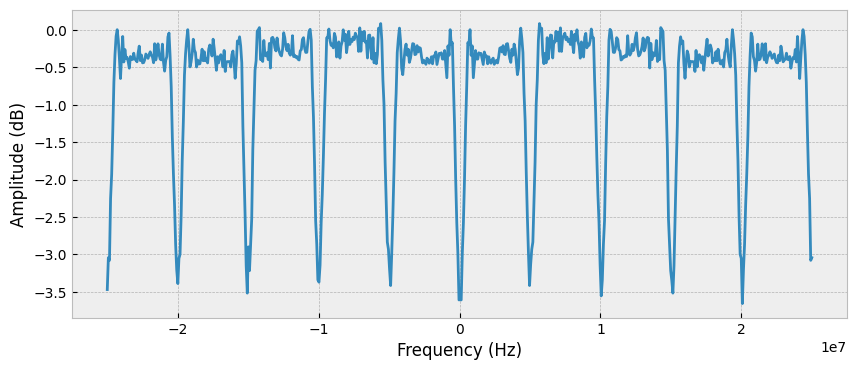

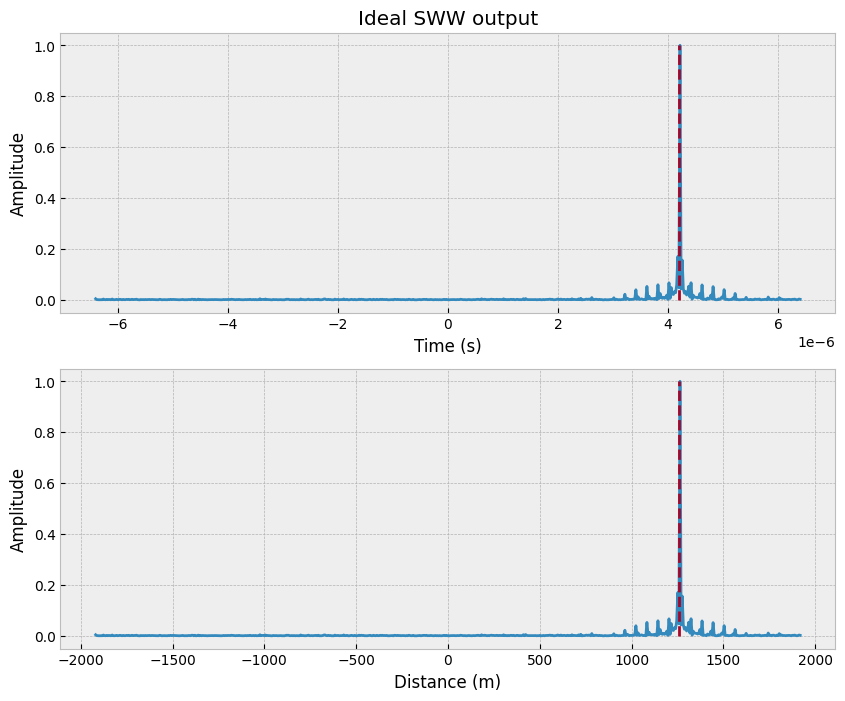

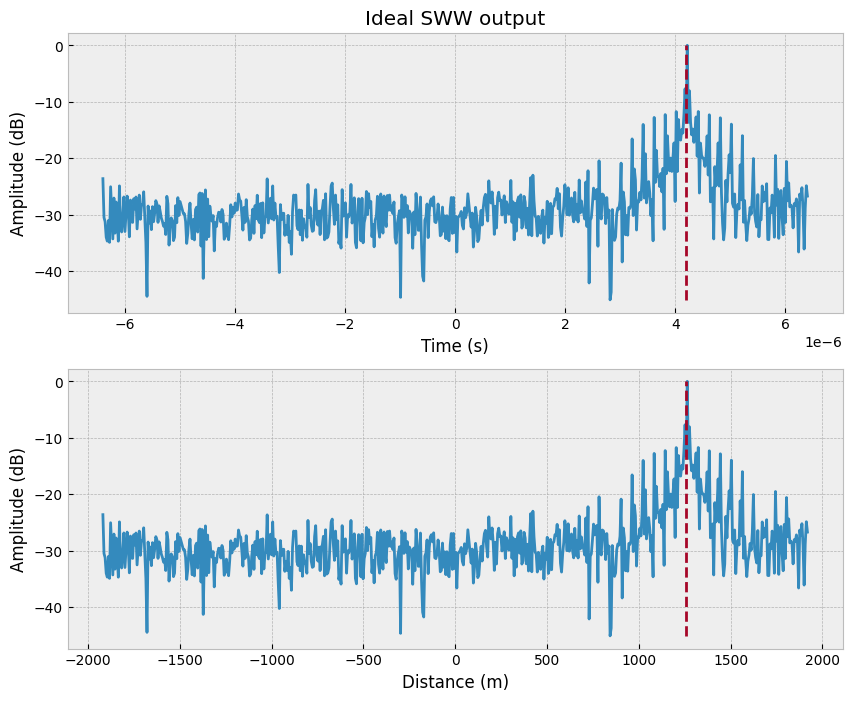

530
4.196557120500783e-06
4.21658841940532e-06
4.236619718309858e-06
4.2e-06


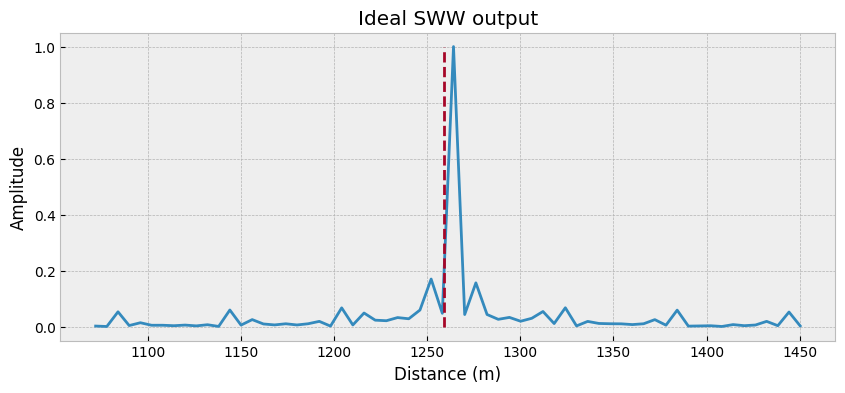

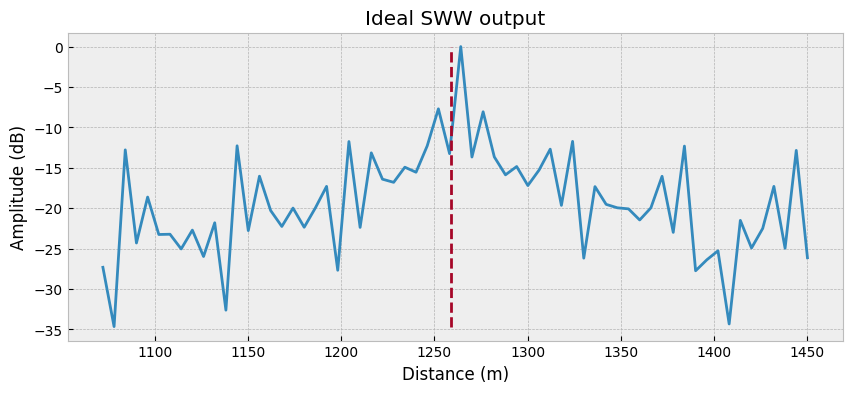

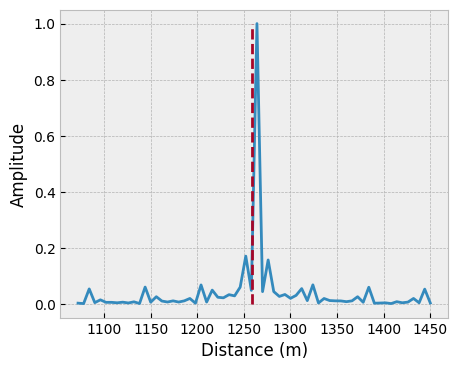

In [10]:
mag_stack = 10*np.log10(np.abs(dft_stack/np.max(dft_stack)))

N2 = int(N/2)

freqs_stack = np.linspace(-Bi*nsp, Bi*nsp, num=Nf*2)

f, ax = plt.subplots(figsize = (10,4))

ax.plot(freqs_stack, mag_stack)
#ax.plot(np.full(10, 0), np.linspace(min(mag_stack), max(mag_stack), 10), linestyle = "--")

ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Amplitude (dB)")

#ax.set_title("Reconstructed SWW")
plt.savefig('recon_sww' + str(nsp) + '.png', dpi=300)


plt.show()

sww = ifftshift(ifft(dft_stack))#Ifft
sww /= np.max(sww)

#New time and distance vectors, note an increase in resolution prop to nsp
t_out = np.linspace(-Tp/2, Tp/2, N*nsp)
dist = t_out * c

f, ax = plt.subplots(2,1, figsize = (10,8))

ax[0].plot(t_out, np.abs(sww))
ax[0].plot(np.full(10, time_delay), np.linspace(0, max(sww), 10), linestyle = "--")
ax[1].plot(dist, np.abs(sww))
ax[1].plot(np.full(10, time_delay*c), np.linspace(0, max(sww), 10), linestyle = "--")


ax[0].set_xlabel("Time (s)")
ax[1].set_xlabel("Distance (m)")

ax[0].set_ylabel("Amplitude")
ax[1].set_ylabel("Amplitude")

ax[0].set_title("Ideal SWW output")

plt.show()

p = 10*np.log10(np.abs(sww))

f, ax = plt.subplots(2,1, figsize = (10,8))

ax[0].plot(t_out, p)
ax[0].plot(np.full(10, time_delay), np.linspace(min(p), max(p), 10), linestyle = "--")
ax[1].plot(dist, p)
ax[1].plot(np.full(10, time_delay*c), np.linspace(min(p), max(p), 10), linestyle = "--")


ax[0].set_xlabel("Time (s)")
ax[1].set_xlabel("Distance (m)")

ax[0].set_ylabel("Amplitude (dB)")
ax[1].set_ylabel("Amplitude (dB)")

ax[0].set_title("Ideal SWW output")

plt.show()

idx = np.argmax(p)
print(idx)
print(t_out[int(idx)-1])
print(t_out[int(idx)])
print(t_out[int(idx)+1])
print(time_delay)

x_arr = dist[int(idx -Nf/10): int(idx + Nf/10)]
p_arr = p[int(idx - Nf/10): int(idx + Nf/10)]
sww_arr = sww[int(idx - Nf/10): int(idx + Nf/10)]

f, ax = plt.subplots(figsize = (10,4))

ax.plot(x_arr, np.abs(sww_arr))
ax.plot(np.full(10, time_delay*c), np.linspace(0, max(sww_arr), 10), linestyle = "--")

ax.set_xlabel("Distance (m)")
ax.set_ylabel("Amplitude")
ax.set_title("Ideal SWW output")

plt.show()

f, ax = plt.subplots(figsize = (10,4))

ax.plot(x_arr, p_arr)
ax.plot(np.full(10, time_delay*c), np.linspace(min(p_arr), max(p_arr), 10), linestyle = "--")

ax.set_xlabel("Distance (m)")
ax.set_ylabel("Amplitude (dB)")
ax.set_title("Ideal SWW output")

plt.show()

x_arr = dist[int(idx -Nf/10): int(idx + Nf/10)]
p_arr = p[int(idx - Nf/10): int(idx + Nf/10)]
sww_arr = np.abs(sww[int(idx - Nf/10): int(idx + Nf/10)])

f, ax = plt.subplots(figsize = (5,4))

ax.plot(x_arr, np.abs(sww_arr))
ax.plot(np.full(10, time_delay*c), np.linspace(min(sww_arr), max(sww_arr), 10), linestyle = "--")

ax.set_xlabel("Distance (m)")
ax.set_ylabel("Amplitude")

plt.savefig('sww' + str(nsp) + '.png', dpi=300)


plt.show()